<a href="https://colab.research.google.com/github/ecrinyetim/traffic-sign-classification-model/blob/main/traffic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle opencv-python-headless scikit-image imutils matplotlib

import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -p /content

!unzip -q /content/*.zip -d /content/gtsrb || true

!ls -la /content/gtsrb


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 97% 596M/612M [00:01<00:00, 311MB/s]
100% 612M/612M [00:01<00:00, 398MB/s]
total 3092
drwxr-xr-x  8 root root    4096 Oct  6 15:13 .
drwxr-xr-x  1 root root    4096 Oct  6 15:13 ..
drwxr-xr-x  2 root root    4096 Oct  6 15:13 meta
drwxr-xr-x  2 root root    4096 Oct  6 15:13 Meta
-rw-r--r--  1 root root    1033 Oct 13  2019 Meta.csv
drwxr-xr-x  2 root root  380928 Oct  6 15:13 test
drwxr-xr-x  2 root root  380928 Oct  6 15:13 Test
-rw-r--r--  1 root root  427897 Oct 13  2019 Test.csv
drwxr-xr-x 45 root root    4096 Oct  6 15:13 train
drwxr-xr-x 45 root root    4096 Oct  6 15:13 Train
-rw-r--r--  1 root root 1940896 Oct 13  2019 Train.csv


In [ ]:
import os, glob, shutil, pandas as pd

base = "/content/gtsrb"
train_folder = None

print("İçerik örnekleri:", os.listdir(base)[:20])

for p in ["Train", "train", "GTSRB/Train", "gtsrb-german-traffic-sign/Train"]:
    cand = os.path.join(base, p)
    if os.path.exists(cand):
        train_folder = cand
        break

if train_folder is None:
    csv_candidates = glob.glob(os.path.join(base, "**", "Train.csv"), recursive=True)
    if len(csv_candidates) == 0:
        print(" Train dizini bulunamadı!")
    else:
        csv_path = csv_candidates[0]
        print("CSV bulundu:", csv_path)
        df = pd.read_csv(csv_path)
        if 'Path' in df.columns and 'ClassId' in df.columns:
            train_folder = os.path.join(base, 'Train')
            os.makedirs(train_folder, exist_ok=True)
            for _, row in df.iterrows():
                src = os.path.join(os.path.dirname(csv_path), row['Path'])
                label = str(row['ClassId'])
                dst_dir = os.path.join(train_folder, label)
                os.makedirs(dst_dir, exist_ok=True)
                dst = os.path.join(dst_dir, os.path.basename(row['Path']))
                if os.path.exists(src) and (not os.path.exists(dst)):
                    shutil.copy(src, dst)
            print("Resimler klasörlere kopyalandı")
else:
    print("Train klasörü bulundu:", train_folder)
    sample_subdirs = [d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))]
    print(f"Alt klasör sayısı: {len(sample_subdirs)}")

İçerik örnekleri: ['Meta.csv', 'train', 'Test', 'Test.csv', 'Train', 'Meta', 'meta', 'test', 'Train.csv']
Train klasörü bulundu: /content/gtsrb/Train
Alt klasör sayısı: 43


In [ ]:
#hücre4
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (48, 48)
BATCH = 64  # 32'den 64'e çıkardım - daha stabil gradients

# Training augmentation - AZALTILMIŞ (overfit'i önlemek için)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


train_gen = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_gen.num_classes
print(f"Sınıf sayısı: {num_classes}")
print(f" Train samples: {train_gen.samples}")
print(f" Val samples: {val_gen.samples}")

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Sınıf sayısı: 43
 Train samples: 31368
 Val samples: 7841


In [ ]:
#hücre5
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dropout,
                                      Dense, BatchNormalization, GlobalAveragePooling2D,
                                      Activation, SpatialDropout2D)
from tensorflow.keras.regularizers import l2

def build_optimized_model(width, height, depth, classes):
    """
    Overfit'i önlemek için optimize edilmiş mimari:
    - Daha az parametre
    - Daha fazla regularization
    - Progressive dropout
    """
    model = Sequential(name='TrafficSignNet')
    inputShape = (height, width, depth)

    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(0.001),
                     input_shape=inputShape, name='conv1_1'))
    model.add(BatchNormalization(name='bn1_1'))
    model.add(Activation('relu', name='relu1_1'))
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(0.001), name='conv1_2'))
    model.add(BatchNormalization(name='bn1_2'))
    model.add(Activation('relu', name='relu1_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='pool1'))
    model.add(SpatialDropout2D(0.3, name='spatial_drop1'))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.001), name='conv2_1'))
    model.add(BatchNormalization(name='bn2_1'))
    model.add(Activation('relu', name='relu2_1'))
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.001), name='conv2_2'))
    model.add(BatchNormalization(name='bn2_2'))
    model.add(Activation('relu', name='relu2_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='pool2'))
    model.add(SpatialDropout2D(0.3, name='spatial_drop2'))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.005), name='conv3_1'))
    model.add(BatchNormalization(name='bn3_1'))
    model.add(Activation('relu', name='relu3_1'))
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.005), name='conv3_2'))
    model.add(BatchNormalization(name='bn3_2'))
    model.add(Activation('relu', name='relu3_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='pool3'))
    model.add(SpatialDropout2D(0.3, name='spatial_drop3'))

    model.add(GlobalAveragePooling2D(name='global_avg_pool'))
    model.add(Dropout(0.4, name='dropout_fc'))

    model.add(Dense(256, kernel_regularizer=l2(0.005), name='fc1'))
    model.add(BatchNormalization(name='bn_fc'))
    model.add(Activation('relu', name='relu_fc'))
    model.add(Dropout(0.4, name='dropout_final'))

    model.add(Dense(classes, activation='softmax', name='output'))

    return model

In [ ]:
#hücre6
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, TensorBoard)
from tensorflow.keras.optimizers import Adam
import datetime

model = build_optimized_model(48, 48, 3, num_classes)

print("\n📋 MODEL MİMARİSİ:")
model.summary()
print(f"\n📊 Toplam parametre sayısı: {model.count_params():,}")

model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)



early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)

checkpoint = ModelCheckpoint(
    'best_traffic_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

print("\n🚀 EĞİTİM BAŞLIYOR...\n")
H = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=60,
    callbacks=[early_stop, reduce_lr, checkpoint, tensorboard],
    verbose=1
)

print("\n✅ EĞİTİM TAMAMLANDI!")
print(f"🎯 En iyi val_accuracy: {max(H.history['val_accuracy']):.4f}")
print(f"📉 En düşük val_loss: {min(H.history['val_loss']):.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📋 MODEL MİMARİSİ:


Model: "TrafficSignNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 48, 48, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_1 (Activation)            │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 48, 48, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_2 (Activation)            │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_drop1                   │ (None, 24, 24, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 24, 24, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_1 (Activation)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 24, 24, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_2 (Activation)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_drop2                   │ (None, 12, 12, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 12, 12, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_1 (Activation)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 12, 12, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_2 (Activation)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_drop3                   │ (None, 6, 6, 128)      │             

 Total params: 333,899 (1.27 MB)

 Trainable params: 332,491 (1.27 MB)

 Non-trainable params: 1,408 (5.50 KB)


📊 Toplam parametre sayısı: 333,899

🚀 EĞİTİM BAŞLIYOR...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.0663 - loss: 5.7024 - top3_acc: 0.1749
Epoch 1: val_accuracy improved from -inf to 0.11631, saving model to best_traffic_model.keras
491/491 ━━━━━━━━━━━━━━━━━━━━ 76s 120ms/step - accuracy: 0.0664 - loss: 5.7015 - top3_acc: 0.1750 - val_accuracy: 0.1163 - val_loss: 4.7064 - val_top3_acc: 0.2613 - learning_rate: 3.0000e-04
Epoch 2/60
214/491 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.1304 - loss: 4.5558 - top3_acc: 0.3082

KeyboardInterrupt: 

In [ ]:
if int(tf.__version__.split(".")[0]) >= 2:
    model.save("best_traffic_model.keras")
else:
    model.save("best_traffic_model.h5")

try:
    model = load_model("best_traffic_model.keras")
except:
    model = load_model("best_traffic_model.h5")


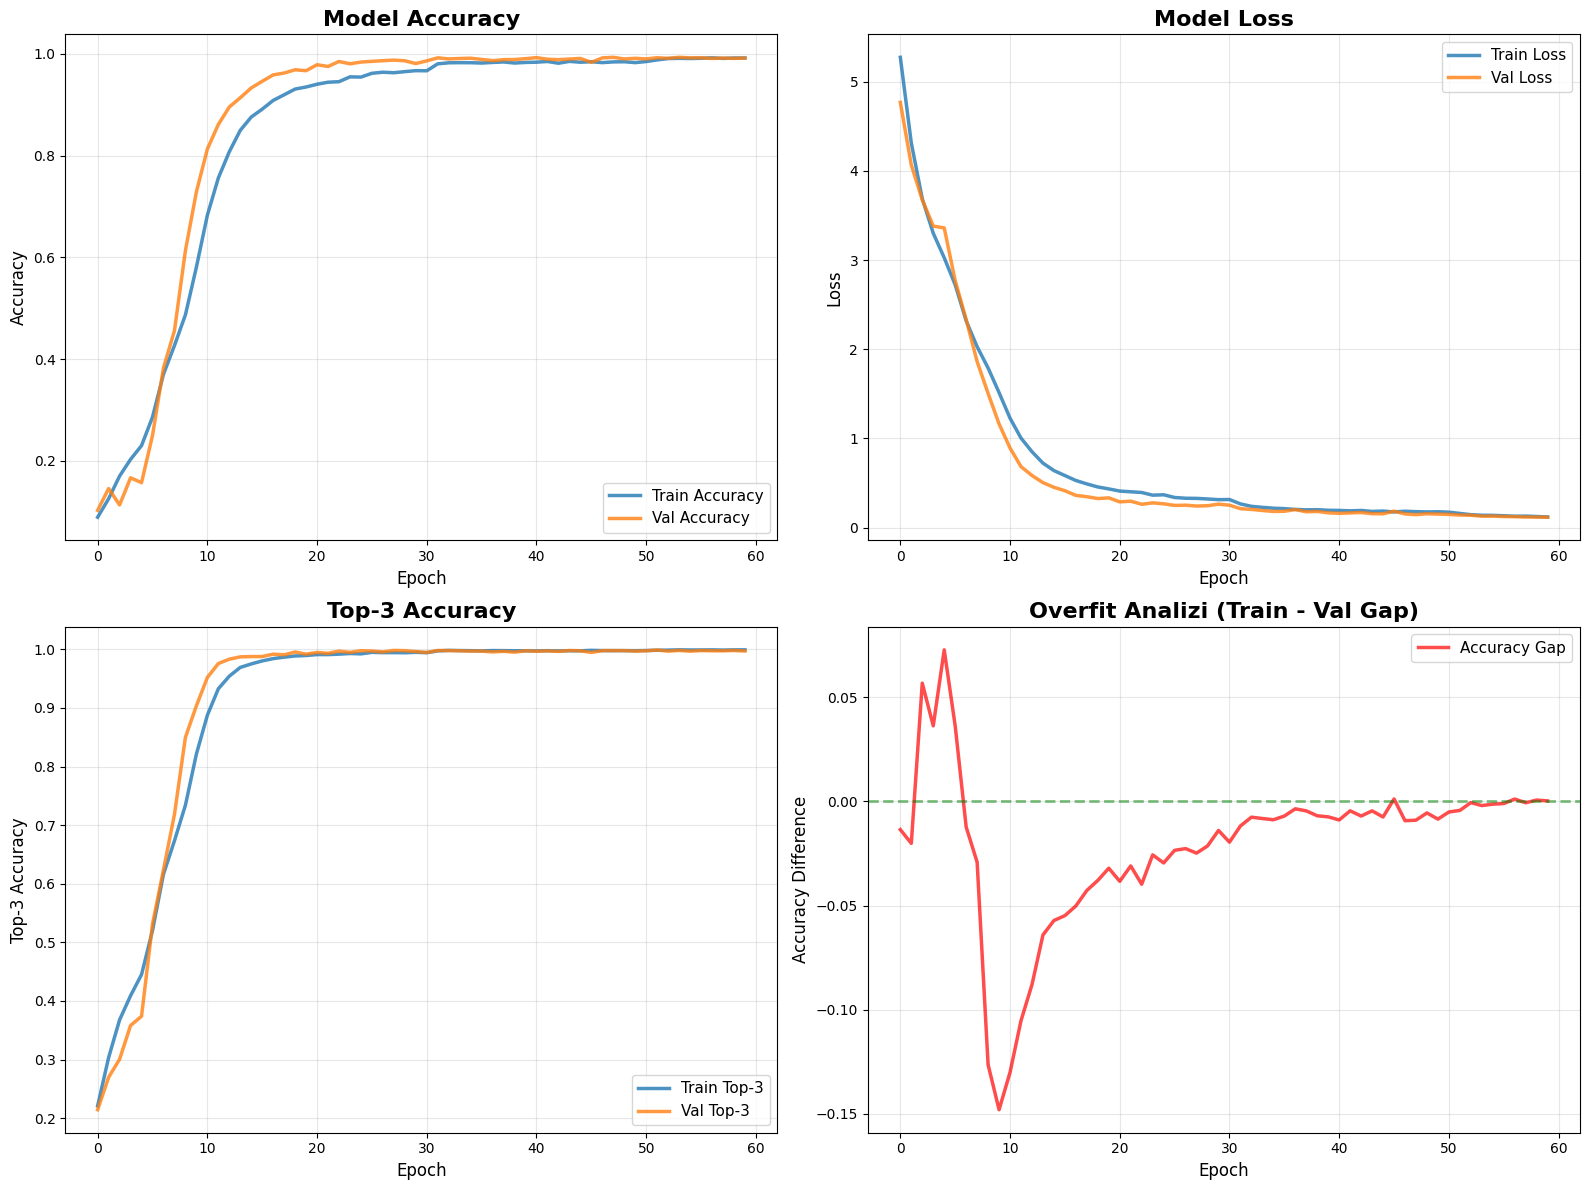

In [ ]:
#hücre7
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0,0].plot(H.history['accuracy'], label='Train Accuracy', linewidth=2.5, alpha=0.8)
axes[0,0].plot(H.history['val_accuracy'], label='Val Accuracy', linewidth=2.5, alpha=0.8)
axes[0,0].set_title('Model Accuracy', fontsize=16, fontweight='bold')
axes[0,0].set_xlabel('Epoch', fontsize=12)
axes[0,0].set_ylabel('Accuracy', fontsize=12)
axes[0,0].legend(loc='lower right', fontsize=11)
axes[0,0].grid(True, alpha=0.3)

# Loss
axes[0,1].plot(H.history['loss'], label='Train Loss', linewidth=2.5, alpha=0.8)
axes[0,1].plot(H.history['val_loss'], label='Val Loss', linewidth=2.5, alpha=0.8)
axes[0,1].set_title('Model Loss', fontsize=16, fontweight='bold')
axes[0,1].set_xlabel('Epoch', fontsize=12)
axes[0,1].set_ylabel('Loss', fontsize=12)
axes[0,1].legend(loc='upper right', fontsize=11)
axes[0,1].grid(True, alpha=0.3)

# Top-3 Accuracy
if 'top3_acc' in H.history:
    axes[1,0].plot(H.history['top3_acc'], label='Train Top-3', linewidth=2.5, alpha=0.8)
    axes[1,0].plot(H.history['val_top3_acc'], label='Val Top-3', linewidth=2.5, alpha=0.8)
    axes[1,0].set_title('Top-3 Accuracy', fontsize=16, fontweight='bold')
    axes[1,0].set_xlabel('Epoch', fontsize=12)
    axes[1,0].set_ylabel('Top-3 Accuracy', fontsize=12)
    axes[1,0].legend(loc='lower right', fontsize=11)
    axes[1,0].grid(True, alpha=0.3)

# Overfit analizi
axes[1,1].plot(np.array(H.history['accuracy']) - np.array(H.history['val_accuracy']),
               label='Accuracy Gap', linewidth=2.5, color='red', alpha=0.7)
axes[1,1].axhline(y=0, color='green', linestyle='--', linewidth=2, alpha=0.5)
axes[1,1].set_title('Overfit Analizi (Train - Val Gap)', fontsize=16, fontweight='bold')
axes[1,1].set_xlabel('Epoch', fontsize=12)
axes[1,1].set_ylabel('Accuracy Difference', fontsize=12)
axes[1,1].legend(fontsize=11)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
#hücre8
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model

# Modeli yükle
model = load_model('best_traffic_model.keras')

# Sınıf isimleri
CLASSES = {
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)',
    9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield',
    14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry', 18: 'General caution', 19: 'Dangerous curve left',
    20: 'Dangerous curve right', 21: 'Double curve', 22: 'Bumpy road',
    23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work',
    26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing',
    29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing',
    32: 'End of all speed and passing limits', 33: 'Turn right ahead',
    34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right',
    37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left',
    40: 'Roundabout mandatory', 41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

def preprocess_image(image_path):
    """Gelişmiş preprocessing pipeline"""
    img = cv2.imread(image_path)
    if img is None:
        return None

    # RGB'ye çevir
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    img_resized = cv2.resize(img_rgb, (48, 48))

    # CLAHE uygulama
    img_yuv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    img_enhanced = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    # Normalize
    img_norm = img_enhanced / 255.0

    return np.expand_dims(img_norm, axis=0)

def predict_with_confidence(image_path, threshold=0.5):
    """Güven skoru ile tahmin"""
    img_input = preprocess_image(image_path)
    if img_input is None:
        return None, None, None, None

    predictions = model.predict(img_input, verbose=0)[0]

    # Top-3 sınıf
    top3_idx = np.argsort(predictions)[-3:][::-1]
    top3_probs = predictions[top3_idx]

    class_id = top3_idx[0]
    confidence = top3_probs[0]

    if confidence >= 0.85:
        status = "YÜKSEK GÜVEN"
    elif confidence >= 0.65:
        status = "ORTA GÜVEN"
    else:
        status = "DÜŞÜK GÜVEN"

    return class_id, confidence, (top3_idx, top3_probs), status

# Test loop
print("\n" + "="*80)
print("🚦 MODEL TEST BAŞLIYOR".center(80))
print("="*80 + "\n")

results = []
for i in range(43):
    # Dosya adı 00000.png, 00001.png ... şeklinde
    path = f"/content/gtsrb/Test/{str(i).zfill(5)}.png"

    if not os.path.exists(path):
        print(f"  #{i:05d}: Dosya bulunamadı")
        continue

    result = predict_with_confidence(path)
    if result[0] is not None:
        class_id, conf, (top3_idx, top3_probs), status = result
        results.append((i, class_id, conf))

        print(f"\nTest #{i:05d} | {status}")
        print(f"├─ Gerçek: {CLASSES[i]}")
        print(f"├─ Tahmin: {CLASSES[class_id]} ({conf:.2%})")
        print(f"└─ Top-3: {CLASSES[top3_idx[0]]} ({top3_probs[0]:.2%}), "
              f"{CLASSES[top3_idx[1]]} ({top3_probs[1]:.2%}), "
              f"{CLASSES[top3_idx[2]]} ({top3_probs[2]:.2%})")

if results:
    avg_conf = np.mean([conf for _, _, conf in results])

    print("\n" + "="*80)
    print(" TEST SONUÇLARI".center(80))
    print("="*80)
    print(f" Ortalama Güven: {avg_conf:.2%}")
    print("="*80)



                             🚦 MODEL TEST BAŞLIYOR                              


Test #00000 | YÜKSEK GÜVEN
├─ Gerçek: Speed limit (20km/h)
├─ Tahmin: Speed limit (120km/h) (100.00%)
└─ Top-3: Speed limit (120km/h) (100.00%), Keep right (0.00%), Road narrows on the right (0.00%)

Test #00001 | YÜKSEK GÜVEN
├─ Gerçek: Speed limit (30km/h)
├─ Tahmin: Speed limit (30km/h) (100.00%)
└─ Top-3: Speed limit (30km/h) (100.00%), Speed limit (20km/h) (0.00%), Double curve (0.00%)

Test #00002 | YÜKSEK GÜVEN
├─ Gerçek: Speed limit (50km/h)
├─ Tahmin: End of all speed and passing limits (100.00%)
└─ Top-3: End of all speed and passing limits (100.00%), Children crossing (0.00%), Yield (0.00%)

Test #00003 | YÜKSEK GÜVEN
├─ Gerçek: Speed limit (60km/h)
├─ Tahmin: Pedestrians (99.99%)
└─ Top-3: Pedestrians (99.99%), Beware of ice/snow (0.01%), Keep left (0.00%)

Test #00004 | YÜKSEK GÜVEN
├─ Gerçek: Speed limit (70km/h)
├─ Tahmin: Speed limit (60km/h) (100.00%)
└─ Top-3: Speed limit (60km/h) (100